In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import pandas as pd
import datetime
import numpy as np
import time as time
import pickle
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import random
import networkx as nx
from sklearn.metrics import classification_report
from tqdm import tqdm
tqdm.pandas()

from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# CSV Loading

In [ ]:
song_data = pd.read_csv("drive/MyDrive/TESI MIRKO/songs_final.csv")
user_data = pd.read_csv("drive/MyDrive/TESI MIRKO//user_data_final.csv")

In [ ]:
# tolgo dalle canzoni totali quelle senza dati di ascolto (0 listenings)
listened_songs = user_data["song_id"].drop_duplicates()
song_data = song_data[song_data["song_id"].isin(listened_songs)]

# User data splitting

In [ ]:
# write dict
set_dict = {}

def add_to_dict(key, value):
    #print(key)
    set_dict[key] = value

def train_test_set(x):
    if len(x)<5:
        x.apply(lambda y: add_to_dict(y["triple_id"], "train"), axis=1)
    else:
        x = x.sample(frac=1)
        train_set = x.head(int(round(len(x)*(0.8))))
        train_set.apply(lambda y: add_to_dict(y["triple_id"], "train"), axis=1)
        test_set = x.tail(int(round(len(x)*(0.2))))
        test_set.apply(lambda y: add_to_dict(y["triple_id"], "test"), axis=1)

# user_data.groupby('user').progress_apply(train_test_set)

In [ ]:
# load csv justpartitioned
user_data_total = pd.read_csv("drive/MyDrive/TESI MIRKO/user_data_partitioned_val.csv")
# user_data_total = user_data

In [ ]:
# load training data labels
user_data = user_data_total[user_data_total["set"]!="test"]

# Creazione ipergrafo

In [ ]:
# dataframe with listend songs

user_hyperedges = user_data.groupby('user')['song_id'].apply(list).reset_index(name='songs')
user_hyperedges["user_id"] = "u_"+(user_hyperedges.index.map(str))
user_hyperedges["user_id_matrix"] = user_hyperedges.index

In [ ]:
# add new user ids and data
user_data = user_data.merge(user_hyperedges, on="user", how="left").set_index(user_data.columns.values[0])
user_data = user_data[["user_id","user_id_matrix","song_id","play_count","triple_id","set"]]
# user_data = user_data[["user","user_id","user_id_matrix","song_id","play_count","triple_id","set"]]

In [ ]:
# dataframe per releases

release_hyperedges = song_data.groupby(['artist_name','release'])['song_id'].apply(list).reset_index(name='songs')
release_hyperedges["release_id"] = "r_"+(release_hyperedges.index.map(str))
print(release_hyperedges)

                                       artist_name  ... release_id
0                                     'Til Tuesday  ...        r_0
1                                    ...And Oceans  ...        r_1
2     ...And You Will Know Us By The Trail Of Dead  ...        r_2
3     ...And You Will Know Us By The Trail Of Dead  ...        r_3
4                                         10 Years  ...        r_4
...                                            ...  ...        ...
5950                          the bird and the bee  ...     r_5950
5951                          the bird and the bee  ...     r_5951
5952                          the bird and the bee  ...     r_5952
5953                                     zebrahead  ...     r_5953
5954                                     zebrahead  ...     r_5954

[5955 rows x 4 columns]


In [ ]:
# dataframe per artists

artists_hyperedges = song_data.groupby('artist_name')['song_id'].apply(list).reset_index(name='songs')
artists_hyperedges["artist_id"] = "a_"+(artists_hyperedges.index.map(str))
print(artists_hyperedges)

                                       artist_name  ... artist_id
0                                     'Til Tuesday  ...       a_0
1                                    ...And Oceans  ...       a_1
2     ...And You Will Know Us By The Trail Of Dead  ...       a_2
3                                         10 Years  ...       a_3
4                                    10000 Maniacs  ...       a_4
...                                            ...  ...       ...
2897                                          moe.  ...    a_2897
2898                                    rinôçérôse  ...    a_2898
2899                                  silent force  ...    a_2899
2900                          the bird and the bee  ...    a_2900
2901                                     zebrahead  ...    a_2901

[2902 rows x 3 columns]


In [ ]:
# dataframe per tag

tags_hyperedges = pd.DataFrame(columns=["tag","tag_id","songs"])

tag_dict = {}

def add_tag_edges(tag_song_row):
    tags = eval(tag_song_row[1])
    for tag in tags:
        if tag_dict.get(tag) == None:
            tag_dict[tag] = {}
            tag_dict[tag]["songs"] = []
            tag_dict[tag]["tag_id"] = "t_" + str(len(tag_dict)-1)
        tag_dict[tag]["songs"].append(tag_song_row[0])
        
song_data[["song_id", "tags"]].apply(add_tag_edges, axis=1)
                    
print(tag_dict["emo"])

{'songs': ['SOWWQXA12A81C1F9CA', 'SOHGWZL12A6D4FA43C', 'SOQZZOG12A8C1327A1', 'SOAXATS12A8C13F6D4', 'SOYDERO12A6D4F72BC', 'SONMWXV12AB01803B4', 'SODCBAA12A6D4FB161', 'SOPISCV12A8C141E97', 'SOFVHFL12A6D4F7B77', 'SOPZPTB12A8C13B8E2', 'SODNRDS12A8C13B8FB', 'SOTNOZN12A8C13D71E', 'SOUTGUB12AB017DC5B', 'SOYVAYO12A67AE17EA', 'SOYJIYN12A8C1345E9', 'SOMOKCH12A8159E8A0', 'SOOQQDQ12A8AE47CA9', 'SOEWXIQ12A6D4FA43E', 'SOPUWDQ12A8C13EB11', 'SOVUZFR12AF72A7A6B', 'SOHHHQS12AC9075465', 'SOPPPGZ12A6D4FD258', 'SONFKXT12AB0187C95', 'SOLQGJA12A6310DF4E', 'SODTRQE12AB017FEAC', 'SOEJMDR12A58A7E62A', 'SONULCN12AB017F8F9', 'SOHSVAE12A8C13E698', 'SOYECAU12A67021CC9', 'SOAFNMY12AB017FB32', 'SOCGVMO12A67AE24CC', 'SORJSEC12A6D4FA5E3', 'SOPKWEY12A67020C3B', 'SOFYXUS12A58A7B5A8', 'SOZBLGH12A670215FA', 'SOBOVPR12A58A7AA8E', 'SOJPQMP12A8C13B376', 'SOIHBCH12A6D4F7CAD', 'SODAABQ12AF72AD08C', 'SOOQBJF12A6D4FA8CA', 'SOGQMYP12A6D4F85AE', 'SOLCPEJ12AB017EDB6', 'SOFPZCI12A58A7CF79', 'SOOMVIQ12A3F1EA127', 'SOVOBOF12A6D4F6612',

In [ ]:
# dict with hyperedges

hyperedges = {}

In [ ]:
# hyperedge users

def add_user_edges(user_row):
    hyperedges[user_row['user_id']] = {}
    hyperedges[user_row['user_id']]['members'] = user_row['songs']
    hyperedges[user_row['user_id']]['members'].append(user_row['user_id'])
    hyperedges[user_row['user_id']]['category'] = 'user'
user_hyperedges.apply(add_user_edges, axis=1)

# hyperedge releases
def add_release_edges(release_row):
    hyperedges[release_row['release_id']] = {}
    hyperedges[release_row['release_id']]['members'] = release_row['songs']
    hyperedges[release_row['release_id']]['members'].append(release_row['release_id'])
    hyperedges[release_row['release_id']]['category'] = 'release'
release_hyperedges.apply(add_release_edges, axis=1)

# hyperedge artists
def add_artist_edges(artist_row):
    hyperedges[artist_row['artist_id']] = {}
    hyperedges[artist_row['artist_id']]['members'] = artist_row['songs']
    hyperedges[artist_row['artist_id']]['members'].append(artist_row['artist_id'])
    hyperedges[artist_row['artist_id']]['category'] = 'artist'
artists_hyperedges.apply(add_artist_edges, axis=1)

# hyperedge tags
for tag in tag_dict:
    tag_id = tag_dict[tag]["tag_id"]
    hyperedges[tag_id] = {}
    hyperedges[tag_id]['members'] = tag_dict[tag]["songs"]
    hyperedges[tag_id]['members'].append(tag_id)
    hyperedges[tag_id]['category'] = 'tag'

In [ ]:
print(hyperedges['u_30'])
print(hyperedges['r_30'])
print(hyperedges['a_2'])
print(hyperedges['t_300'])

{'members': ['SOHMFDH12AB0186FCA', 'SOSARYL12A8AE45CEC', 'SOTVLQY12A58A798C2', 'SOUOEMP12A8C13866E', 'SOXOUHM12A8AE45D07', 'u_30'], 'category': 'user'}
{'members': ['SOKSAZO12A8C131ED4', 'SOMQXZL12A8C131EDA', 'SOQIDQM12A8C1324C3', 'SOXDJVM12A8C131EC7', 'r_30'], 'category': 'release'}
{'members': ['SOGQNZJ12A6701F1D6', 'SOCIAPE12A6701C614', 'SOXYUWN12A6701C617', 'a_2'], 'category': 'artist'}
{'members': ['SOOLSML12A8C1414DC', 'SOWSQIA12A58A78B5A', 'SOYUPIO12A6D4FD477', 'SOYSBYZ12A8C1427C8', 'SOZHWZB12AB0182B9D', 't_300'], 'category': 'tag'}


In [ ]:
# compute hyperedges max_size e min_size

max_size = 0
min_size = 100000

for h_index in hyperedges:
    members = hyperedges[h_index]["members"]
    if len(members) < min_size:
        min_size = len(members)
    if len(members) > max_size:
        max_size = len(members)

print(min_size, max_size)

2 6986


In [ ]:
# count hyperedge number per category

cat_amounts = {}

for h in hyperedges:
    if hyperedges[h]["category"] not in cat_amounts:
        cat_amounts[hyperedges[h]["category"]] = 1
    else:
        cat_amounts[hyperedges[h]["category"]] += 1
        
print(cat_amounts)

{'user': 918725, 'release': 5955, 'artist': 2902, 'tag': 121849}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


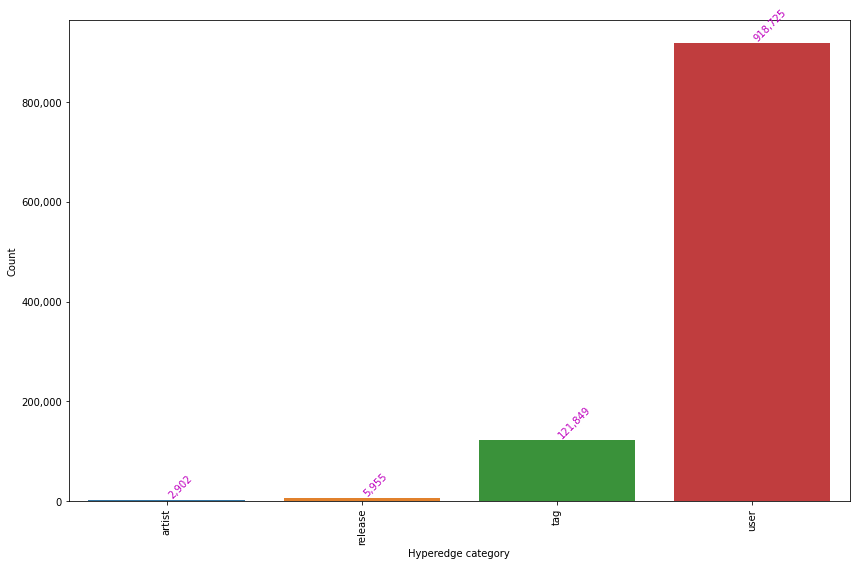

In [ ]:
# plot hyperedges distribution

pd_df = pd.DataFrame(list(cat_amounts.items()))
pd_df.columns = ["Dim", "Count"]
# sort df by Count column
pd_df = pd_df.sort_values(['Count']).reset_index(drop=True)

plt.figure(figsize=(12, 8))
# plot barh chart with index as x values
ax = sns.barplot(pd_df.index, pd_df.Count)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Hyperedge category", ylabel='Count')
# add proper Dim values as x labels
ax.set_xticklabels(pd_df.Dim)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(pd_df["Count"].iteritems()):
    ax.text(i, v[1], "{:,}".format(v[1]), color='m', va='bottom', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# for each node, get hyperedges

vertexMemberships = {}
for h_index in hyperedges:
    hyperedge = hyperedges[h_index]
    nodes = hyperedge["members"]
    for node in nodes:
        if node in vertexMemberships:
            vertexMemberships[node].append(h_index)
        else:
            nodeMembershipList = []
            nodeMembershipList.append(h_index)
            vertexMemberships[node] = nodeMembershipList

print(vertexMemberships['SOZOBWN12A8C130999'])

['u_65', 'u_225', 'u_273', 'u_680', 'u_988', 'u_1032', 'u_1233', 'u_1472', 'u_1663', 'u_2971', 'u_4612', 'u_5313', 'u_5493', 'u_5541', 'u_6417', 'u_6705', 'u_7270', 'u_7965', 'u_8019', 'u_8701', 'u_8820', 'u_9033', 'u_9556', 'u_10410', 'u_10455', 'u_10800', 'u_11478', 'u_11488', 'u_11691', 'u_12001', 'u_12481', 'u_12927', 'u_12937', 'u_13786', 'u_14229', 'u_14637', 'u_14692', 'u_14911', 'u_15007', 'u_16053', 'u_16231', 'u_16547', 'u_16556', 'u_16852', 'u_17422', 'u_17441', 'u_17908', 'u_19598', 'u_19819', 'u_20572', 'u_21247', 'u_21432', 'u_21520', 'u_23622', 'u_23660', 'u_23700', 'u_24199', 'u_24795', 'u_24953', 'u_24999', 'u_25686', 'u_25735', 'u_26139', 'u_26855', 'u_27600', 'u_28516', 'u_28942', 'u_29307', 'u_30886', 'u_32253', 'u_32776', 'u_34789', 'u_35126', 'u_35721', 'u_36227', 'u_36711', 'u_37233', 'u_37378', 'u_37446', 'u_37531', 'u_40009', 'u_40065', 'u_40378', 'u_40581', 'u_40680', 'u_40769', 'u_41108', 'u_42172', 'u_43228', 'u_44553', 'u_46051', 'u_46142', 'u_46164', 'u_46

In [ ]:
# save hyperedges and nodes

print("Salvataggio dati hyperedge e nodi...\n")

print("Numero di hyperedge: " + str(len(hyperedges)))
pickle.dump(hyperedges, open('drive/MyDrive/TESI MIRKO/hyperedges.p', 'wb'))
print("hyperedges.p salvato.\n")
    
print("Numero di nodi: " + str(len(vertexMemberships)))
pickle.dump(vertexMemberships, open('drive/MyDrive/TESI MIRKO/vertexMemberships.p', 'wb'))
print("vertexMemberships.p salvato.\n")
    
print("Salvataggio dati hyperedge e nodi completato.")

Salvataggio dati hyperedge e nodi...

Numero di hyperedge: 1049431
hyperedges.p salvato.

Numero di nodi: 1060311
vertexMemberships.p salvato.

Salvataggio dati hyperedge e nodi completato.


In [ ]:
hyperedges = pickle.load(open('drive/MyDrive/TESI MIRKO/hyperedges.p', 'rb'))
vertexMemberships = pickle.load(open('drive/MyDrive/TESI MIRKO/vertexMemberships.p', 'rb'))

# Compute random walks (SaT e TaS)

In [ ]:
# SubsampleAndTraverse: definisce random walk tra vertici
def SubsampleAndTraverse(length, num_walks, hyperedges, vertexMemberships, alpha=1., beta=0):
    walksSAT = []
    for vertex in vertexMemberships:
        hyperedge_index = random.choice(vertexMemberships[vertex])
        hyperedge = hyperedges[hyperedge_index]
        walk_vertex = []
        curr_vertex = vertex
        for _ in range(num_walks):
            initial=True
            hyperedge_num = hyperedge_index
            curr_hyperedge = hyperedge
            for i in range(length):
                proba = (float(alpha)/len(curr_hyperedge["members"])) + beta
                if random.random()<proba:
                    adjacent_hyperedges = vertexMemberships[curr_vertex]
                    hyperedge_num = random.choice(adjacent_hyperedges)
                    curr_hyperedge = hyperedges[hyperedge_num]
                walk_vertex.append(str(curr_vertex))
                next_nodes = curr_hyperedge["members"][:]
                if curr_vertex in next_nodes: next_nodes.remove(curr_vertex)
                curr_vertex = random.choice(next_nodes)
            walksSAT.append(walk_vertex)    
        if (len(walksSAT) % 100000)==0:
            print(str(len(walksSAT)*100/(num_walks*len(vertexMemberships)))+"%")
    return walksSAT

In [ ]:
walksSAT = SubsampleAndTraverse(length=100,num_walks=10, hyperedges=hyperedges, vertexMemberships=vertexMemberships, alpha=1, beta=0)
# walksSAT = pickle.load(open('drive/MyDrive/TESI MIRKO/walksSAT.p', 'rb'))

In [ ]:
delta = int(10603110 / 50)
for i in range(0,10603110,delta):
    print(i)
    if i + delta < 10603110:
        filename = "walksSAT-" + str(i) + "-" + str(i+delta)
        pickle.dump(walksSAT[i:i+delta], open("drive/MyDrive/TESI MIRKO/walksSAT/" + filename, "wb"))
    else:
        filename = "walksSAT-" + str(i) + "-" + str(10603110)
        pickle.dump(walksSAT[i:], open("drive/MyDrive/TESI MIRKO/walksSAT/" + filename, "wb"))

In [ ]:
import os
import json
import pickle

prova = os.listdir('drive/MyDrive/TESI MIRKO/walksSAT')[1]

f = open('drive/MyDrive/TESI MIRKO/walksSAT/' + prova, 'rb')
lista = pickle.load(f)
f.close()

f = open("drive/MyDrive/TESI MIRKO/walksSAT/prova.json", 'w')
json.dump(lista, f) 
f.close()
with  as f:
  with  as f2:
    

In [ ]:
import os
import gc

walksSAT = []
for f in os.listdir('drive/MyDrive/TESI MIRKO/walksSAT'):
    pikd = open('drive/MyDrive/TESI MIRKO/walksSAT/' + f, 'rb')
    for el in pickle.load(pikd):
      walksSAT.append(el)
    pikd.close()

In [ ]:
import os

walksSAT = []
for ws in os.listdir('drive/MyDrive/TESI MIRKO/walksSAT'):
    walksSAT.append(pickle.load(open('drive/MyDrive/TESI MIRKO/walksSAT/' + ws, 'rb')))

In [ ]:
# salvataggio dati SaT
print("Salvataggio dati SaT...")
pickle.dump(walksSAT, open('drive/MyDrive/TESI MIRKO/walksSAT.p', 'wb'))
print("walksSAT.p salvato.\n")

In [ ]:
import os
import pickle

files = os.listdir('drive/MyDrive/TESI MIRKO/walksSAT')

aggregated = pickle.load(open('drive/MyDrive/TESI MIRKO/walksSAT/' + files[0], 'rb'))
pickle.dump(aggregated, open('drive/MyDrive/TESI MIRKO/walksSAT.p', 'wb'))
os.remove('drive/MyDrive/TESI MIRKO/walksSAT/' + files[0])

for f in files[1:]:
    print(f)
    # aggregated = pickle.load(open('drive/MyDrive/TESI MIRKO/walksSAT.p', 'rb'))
    for el in pickle.load(open('drive/MyDrive/TESI MIRKO/walksSAT/' + f, 'rb')):
        aggregated.append(el)
    pickle.dump(aggregated, open('drive/MyDrive/TESI MIRKO/walksSAT.p', 'wb'))
    os.remove('drive/MyDrive/TESI MIRKO/walksSAT/' + f)

# Generate context embeddings

In [ ]:
from gensim.models.word2vec import Word2Vec
from gensim.models.poincare import PoincareModel, PoincareRelations
from gensim.models.callbacks import CallbackAny2Vec
import time as time

def EmbedWord2Vec(walks,dimension):
    time_start = time.time()
    print("Creating embeddings.")
    model = Word2Vec(walks, size=dimension, window=5, min_count=0, sg=1, workers=16, iter=20)
    node_ids = model.wv.index2word
    node_embeddings = model.wv.vectors
    print("Embedding generation runtime: ", time.time()-time_start)
    return node_ids, node_embeddings

In [ ]:
vertex_embedding_dimension = 200

In [ ]:
import gc
gc.collect()

725

In [ ]:
# creazione embeddings dei nodi
print(datetime.datetime.now())
print("Creazione vertex embeddings...")
vertex_ids, vertex_embeddings = EmbedWord2Vec(walks=walksSAT, dimension=vertex_embedding_dimension)
print(datetime.datetime.now())
print("Vertex embeddings completati. ("+str(len(vertex_embeddings))+" embeddings)")

2021-09-02 18:46:26.757239
Creazione vertex embeddings...
Creating embeddings.


In [ ]:
print("Context embedding per nodo "+vertex_ids[0]+":")
print(vertex_embeddings[0])

In [ ]:
context_embeddings = dict(zip(vertex_ids, vertex_embeddings))
print(context_embeddings['SOAUWYT12A81C206F1'])

In [ ]:
# salvataggio vertex embeddings
print("Salvataggio context embeddings...")
pickle.dump(context_embeddings, open('drive/MyDrive/TESI MIRKO/context_embeddings.p', 'wb'))
print("context_embeddings.p salvato.\n")

# Mood detection (compute arousal e valence per user)

In [ ]:
# get arousal e valence foreach song listened by each user_id

user_data["arousal"] = user_data.merge(song_data, on="song_id", how="left").set_index("triple_id")["arousal"]
user_data["valence"] = user_data.merge(song_data, on="song_id", how="left").set_index("triple_id")["valence"]

In [ ]:
print(user_data[user_data["user_id"]=="u_60"])

In [ ]:
# compute arousal e valence for each user as average of each listend song (weighted on play_count)

user_data['weighted_arousal'] = user_data['arousal'] * user_data['play_count']
user_data['weighted_valence'] = user_data['valence'] * user_data['play_count']

user_mood = user_data.groupby('user_id').agg({'weighted_arousal': 'sum', 'weighted_valence':'sum', 'play_count':'sum'}).reset_index()
user_mood["arousal"] = user_mood["weighted_arousal"]/user_mood["play_count"]
user_mood["valence"] = user_mood["weighted_valence"]/user_mood["play_count"]

print(user_mood)

In [ ]:
print(user_mood[user_mood['user_id']=='u_0'][['user_id','arousal','valence']])

In [ ]:
# load max per feature of each song of each user for max pooling

user_max = user_data.groupby('user_id').agg({'arousal':'max', 'valence':'max'}).reset_index()
user_mood["arousal"] = user_mood["arousal"] + user_max["arousal"]
user_mood["valence"] = user_mood["valence"] + user_max["valence"]

In [ ]:
user_mood.head()

In [ ]:
# compute dict with valence and arousal of song and user

arousal_valence_dict = {}

def generate_arousal_valence_dict(row):
    if arousal_valence_dict.get(row[0]) is None:
        arousal_valence_dict[row[0]] = {}
    arousal_valence_dict[row[0]]["valence"] = row[1]
    arousal_valence_dict[row[0]]["arousal"] = row[2]

user_mood[["user_id", "valence", "arousal"]].progress_apply(generate_arousal_valence_dict, axis=1)

song_data[["song_id", "valence", "arousal"]].progress_apply(generate_arousal_valence_dict, axis=1)

In [ ]:
# sove valence e arousal
print("Salvataggio valence e arousal...")
pickle.dump(arousal_valence_dict, open('arousal_valence_dict.p', 'wb'))
print("arousal_valence_dict.p salvato.\n")

# COncatenate features

In [ ]:
import numpy as np

def generate_embeddings(row, e_dict):
    embedding = np.concatenate((context_embeddings[row[0]], content_embeddings[row[0]]))
    embedding = np.append(embedding,arousal_valence_dict[row[0]]["arousal"])
    embedding = np.append(embedding,arousal_valence_dict[row[0]]["valence"])
    e_dict[row[0]] = embedding

In [ ]:
# creo embedding canzoni
song_embeddings = {}
song_data[["song_id"]].apply(lambda x: generate_embeddings(x, song_embeddings), axis=1)

print("Creati "+str(len(song_embeddings))+" song embedding.")
print(song_embeddings["SOZOBWN12A8C130999"])

In [ ]:
# creo embedding utenti
user_embeddings = {}
user_hyperedges[["user_id"]].progress_apply(lambda x: generate_embeddings(x, user_embeddings), axis=1)

print("Creati "+str(len(user_embeddings))+" user embedding.")

In [ ]:
# salvataggio song embeddings
print("Salvataggio song embeddings...")
pickle.dump(song_embeddings, open('song_embeddings.p', 'wb'))
print("song_embeddings.p salvato.\n")

# salvataggio user embeddings
print("Salvataggio user embeddings...")
pickle.dump(user_embeddings, open('user_embeddings.p', 'wb'))
print("user_embeddings.p salvato.\n")

# Normalizzazione embeddings (Z-Score)

In [ ]:
import numpy as np
from scipy.stats import zscore

song_keys, song_vals = zip(*song_embeddings.items())
song_embeddings = dict(zip(song_keys, zscore(song_vals, ddof=1)))

user_keys, user_vals = zip(*user_embeddings.items())
user_embeddings = dict(zip(user_keys, zscore(user_vals, ddof=1)))

In [ ]:
# salvataggio song embeddings con z-score
print("Salvataggio song embeddings...")
pickle.dump(song_embeddings, open('song_embeddings_zscore.p', 'wb'))
print("song_embeddings_zscore.p salvato.\n")

# salvataggio user embeddings con z-score
print("Salvataggio user embeddings...")
pickle.dump(user_embeddings, open('user_embeddings_zscore.p', 'wb'))
print("user_embeddings_zscore.p salvato.\n")

# Recommendation system (distanza coseno pesata)

In [ ]:
from numpy import dot
from numpy.linalg import norm
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
pd.options.display.max_rows = None

In [ ]:
# cos sim

def cos_sim(a, b, w):
    return 1-spatial.distance.cosine(a, b, w)
    #return dot(a, b)/(norm(a)*norm(b))

In [ ]:
# weights vector
w_1 = np.full(16, 1/(16*3))  # peso context-embedding
w_2 = np.full(25, 1/(25*3))  # peso content-embedding
w_3 = np.full(2, 1/(2*3))    # peso arousal e valence

# vettore peso w (stesso peso ad ogni sistema)
w_equi = np.concatenate((w_1, w_2, w_3), axis=None)

# vettore peso w_context (solo context-based)
w_context = np.concatenate((np.ones(200), np.zeros(25), np.zeros(2)), axis=None)

# vettore peso w_content (solo context-based)
w_content = np.concatenate((np.zeros(16), np.ones(50), np.zeros(2)), axis=None)

# vettore peso w_av (solo context-based)
w_av = np.concatenate((np.zeros(16), np.zeros(25), np.ones(2)), axis=None)

In [ ]:
w_1_mix = np.full(16, 5/(16*3))  # peso context-embedding
w_2_mix = np.full(100, 1/(50*3))  # peso content-embedding
w_3_mix = np.full(2, 0/(2*3))    # peso arousal e valence
w_mix = np.concatenate((w_1_mix, w_2_mix, w_3_mix), axis=None)

In [ ]:
# remove 0 lisetnings

listened_songs = user_data_total["song_id"].drop_duplicates()
song_data_listened = song_data[song_data["song_id"].isin(listened_songs)].reset_index()

# use song unique id for matrix 
song_data_listened["id"] = song_data_listened.index
user_data_total["song_matrix_id"] = user_data_total.merge(song_data_listened, left_on="song_id", right_on="song_id", how="left")["id"]

In [ ]:
# caricamento dati set (per utenti su cui fare la predizione)

#  test set
user_test = user_data_total[user_data_total["set"]=="test"]
user_test = user_test.merge(user_hyperedges, on="user", how="left").set_index(user_test.columns.values[0])[["user","user_id","user_id_matrix","song_id","play_count","triple_id","set",'song_matrix_id']]
users_test_songs = user_test.groupby('user_id_matrix')['song_matrix_id'].apply(list).reset_index(name = "songs")

# training degli utenti nel test set
user_training = user_data_total[user_data_total["set"]=="train"]
user_training = user_training.merge(user_hyperedges, on="user", how="left").set_index(user_training.columns.values[0])[["user","user_id","user_id_matrix","song_id","play_count","triple_id","set",'song_matrix_id']]
user_training = user_training[user_training["user_id_matrix"].isin(users_test_songs["user_id_matrix"])]
users_training_songs = user_training.groupby('user_id_matrix')['song_matrix_id'].apply(list).reset_index(name = "songs")

#test_user_list = user_test.user_id.unique()
#test_song_list = user_test.song_id.unique()
#print(user_training)
#print(user_test)
#print(users_test_songs)

In [ ]:
# compute matrix user/song test set
users_test_matrix = users_test_songs['songs'].tolist()

import scipy.sparse as sp

matrix = sp.lil_matrix((len(users_test_matrix),len(song_data_listened)), dtype=int)
for row in range(len(users_test_matrix)):
    for column in users_test_matrix[row]:
        matrix[row, column] = 1
        
users_test_matrix = matrix

In [ ]:
# compute matrix user/song (only test set users)
users_train_matrix = users_training_songs['songs'].tolist()

import scipy.sparse as sp

matrix = sp.lil_matrix((len(users_train_matrix),len(song_data_listened)), dtype=int)
for row in range(len(users_train_matrix)):
    for column in users_train_matrix[row]:
        matrix[row, column] = 1

users_train_matrix = matrix

In [ ]:
# user_embeddings_to_array
user_hyperedges['embedding'] = user_hyperedges.user_id.map(user_embeddings)
users_test_songs['user_embedding'] = users_test_songs.merge(user_hyperedges, on="user_id_matrix", how="left")["embedding"]
user_embeddings_array = users_test_songs['user_embedding'].tolist()
user_embeddings_array = np.array(user_embeddings_array)

In [ ]:
# song_embeddings to array
song_data_listened['embedding'] = song_data_listened.song_id.map(song_embeddings)
song_embeddings_array = song_data_listened['embedding'].tolist()
song_embeddings_array = np.array(song_embeddings_array)

In [ ]:
# compute scores and top-k prediction for each user

def compute_score_matrix(user_embeddings_array, song_embeddings_array, w):
    num = (user_embeddings_array * w) @ song_embeddings_array.T
    norms_user = ((user_embeddings_array * w) * user_embeddings_array).sum(1, keepdims=True)**.5
    norms_song = ((song_embeddings_array * w) * song_embeddings_array).sum(1, keepdims=True)**.5
    den = norms_user @ norms_song.T
    users_score_matrix = num / den
    return users_score_matrix

print(str(datetime.datetime.now())+" - Start")

i = 0
k = 100
step = 10000
users_predictions = np.zeros((len(user_embeddings_array), k), dtype=int)

while(i<len(user_embeddings_array)):
    
    j = min(i+step, len(user_embeddings_array))
    
    # calcola score
    print(str(datetime.datetime.now())+" - Calcolo scores "+str(i)+"-"+str(j))
    users_score_matrix = compute_score_matrix(user_embeddings_array[i:j], song_embeddings_array, w_context)
    
    # calcola top k suggestions
    print(str(datetime.datetime.now())+" - Rimuovo canzoni di training "+str(i)+"-"+str(j))
    users_score_matrix = users_score_matrix - users_train_matrix[i:j]*2 # peggioro lo score delle canzoni di train per non predirle
    print(str(datetime.datetime.now())+" - Calcolo top k suggestions con argsort "+str(i)+"-"+str(j))        
    users_predictions[i:j] = np.argsort(-users_score_matrix)[:,0:k]
    #print(str(datetime.datetime.now())+" - Calcolo top k suggestions con argpartition "+str(i)+"-"+str(j))          
    #users_predictions[i:j] = np.argpartition(-users_score_matrix, range(k))[:,0:k] # ordino in base allo score e restituisco le prime k

    i = j

print(str(datetime.datetime.now())+" - Fine")
    
    
    #top_k_songs = np.argpartition(users_score_matrix, -k)[:,-k:]
    #for top in range(0,k):
    #    print(top_k_songs[:,top].flatten())
    #    users_pred_matrix[i:(i+u), top_k_songs[:,top].flatten()] = 1
    #print(top_k_songs[0])
    #for u in range(0, step):
        #users_score_matrix[u,users_train_matrix[i+u]] = -1     # dai score minimo alle canzoni di test (per non predirle)
        #top_k_songs = np.argsort(users_score_matrix[u])[0:k]   # ottieni le top k canzoni con score migliore
        #users_pred_matrix[i+u,top_k_songs] = 1                 # segnale nella matrice di predizione
        #if u%100==0: print(u)

In [ ]:
# calcolo predictions per un utente
user_id = random.randint(0, users_predictions.shape[0]-1)
print(user_id)

In [ ]:
# canzoni ascoltate dall'utente
song_data_listened[song_data_listened.id.isin(users_train_matrix.rows[user_id])]

In [ ]:
# top 100 consigli per l'utente
predictions_df = pd.DataFrame({'id':users_predictions[user_id]})
predictions_df["rank"]= predictions_df.index+1
predictions_df.merge(song_data_listened, on='id', how='left').set_index('rank')

In [ ]:
# canzoni del test set dell'utente
song_data_listened[song_data_listened['id'].isin(users_test_matrix.rows[user_id])]

# Evaluation

**Recall e AP**

In [ ]:
def check_true_positives(songs_test, top_songs):
    
    # controlla quante canzoni del test set compaiono
    found = 0
    for test_song in songs_test:
        if test_song in top_songs:
            found += 1
    return found

def AP (songs_test, top_songs):
    
    # average precision
    found = 0
    score = 0
    for i in range(len(songs_test)):
        if songs_test[i] in top_songs:
            found += 1
            score += found/(i+1)
    return score/min(len(songs_test), len(top_songs))

In [ ]:
users_test_matrix.shape

(380906, 10880)

In [ ]:
# compute recall and AP @100/50/20/10/5
print(str(datetime.datetime.now())+" - Start evaluation")

for k in [100, 50, 20, 10, 5]:
    
    true_positives = np.zeros(users_test_matrix.shape[0])
    user_recalls = np.zeros(users_test_matrix.shape[0])
    user_APS = np.zeros(users_test_matrix.shape[0])
    test_songs_n = 0

    for i in range(users_test_matrix.shape[0]):

        test_songs = users_test_matrix.rows[i]
        test_songs_n += len(test_songs)
        predictions = users_predictions[i]

        true_positives[i] = check_true_positives(test_songs, predictions[0:k])

        user_recalls[i] = float(true_positives[i]/(len(test_songs))) 

        user_APS[i] = AP(test_songs, predictions[0:k])

        #print("["+str(i)+"]: "+str(user_recalls[i]*100)+"%")

    macro_recall = np.mean(user_recalls)
    print("Macro-avg Recall@"+str(k)+" (per utente): "+str(macro_recall*100)+"%")
    #micro_recall = np.sum(true_positives)/test_songs_n
    #print("Micro-avg Recall@"+str(k)+" (per canzone): "+str(micro_recall*100)+"%")
    avg_ap = np.mean(user_APS)
    print("AP@"+str(k)+": "+str(avg_ap*100)+"%")

print(str(datetime.datetime.now())+" - End evaluation")